In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Load data and convert categorical to numeric

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-10-25 09:36:07--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2022-10-25 09:36:07 (62.2 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
dataset['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [5]:
dataset['sex'].replace(['male', 'female'],
                        [0, 1], inplace=True)

In [6]:
dataset['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [7]:
dataset['smoker'].replace(['no', 'yes'],
                        [0, 1], inplace=True)

In [8]:
dataset['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [9]:
dataset['region'].replace(['northwest', 'northeast', 'southwest', 'southeast'],
                        [0, 1, 2, 3], inplace=True)

In [10]:
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,0,31.0,3,0,0,10600.55
1334,18,1,31.9,0,0,1,2205.98
1335,18,1,36.9,0,0,3,1629.83
1336,21,1,25.8,0,0,2,2007.95
1337,61,1,29.1,0,1,0,29141.36


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   int64  
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 73.3 KB


# Create train and test datasets

In [12]:
# split dataset into train and test sets (80%-20%)
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

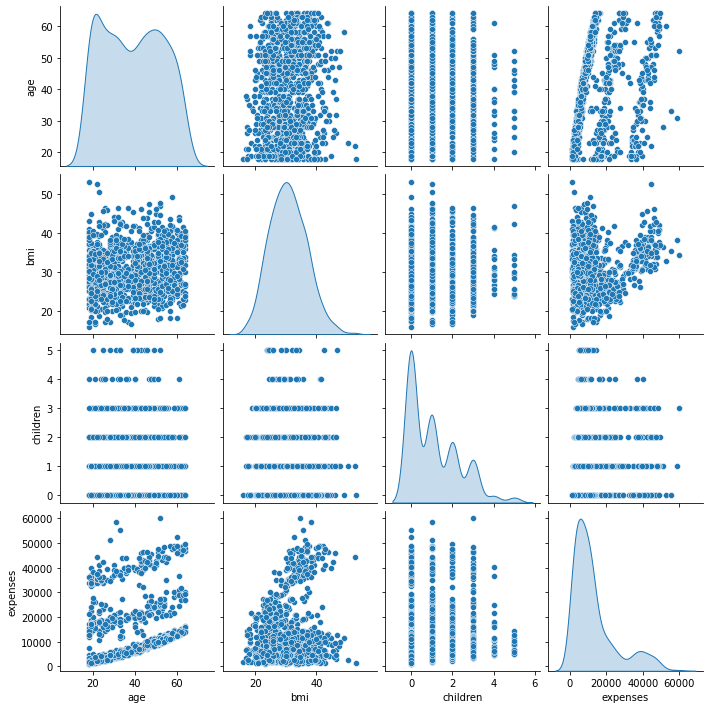

In [13]:
# inspect the data
sns.pairplot(train_dataset[['age', 'bmi', 'children', 'expenses']], diag_kind='kde')

In [14]:
# check statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.036449,14.142122,18.00,26.000,39.000,51.0000,64.0
sex,1070.0,0.501869,0.500230,0.00,0.000,1.000,1.0000,1.0
bmi,1070.0,30.737290,6.065193,16.00,26.300,30.500,34.8000,53.1
children,1070.0,1.093458,1.211364,0.00,0.000,1.000,2.0000,5.0
smoker,1070.0,0.199065,0.399484,0.00,0.000,0.000,0.0000,1.0
region,1070.0,1.561682,1.131829,0.00,1.000,2.000,3.0000,3.0
expenses,1070.0,13056.551654,11994.260172,1121.87,4565.995,9289.085,15826.1125,60021.4


In [15]:
# separate labels from features
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

In [16]:
train_features.describe().transpose()[['mean', 'std']]

,mean,std
age,39.036449,14.142122
sex,0.501869,0.500230
bmi,30.737290,6.065193
children,1.093458,1.211364
smoker,0.199065,0.399484
region,1.561682,1.131829


# Create and train model

In [17]:
# we have quite different value ranges of input variable, so we create a normalization layer for the model
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[39.036446    0.50186914 30.73729     1.093458    0.19906542  1.5616825 ]]


In [18]:
# create and compile model
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)

])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.05),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error', 'mean_squared_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [19]:
# train the model
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=200,
    # Suppress logging.
    #verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


Epoch 1/200
27/27 [==============================] - 1s 15ms/step - loss: 11067.6309 - mean_absolute_error: 11067.6309 - mean_squared_error: 259409856.0000 - val_loss: 7961.0630 - val_mean_absolute_error: 7961.0630 - val_mean_squared_error: 170826624.0000
Epoch 2/200
27/27 [==============================] - 0s 4ms/step - loss: 4992.8657 - mean_absolute_error: 4992.8657 - mean_squared_error: 74341440.0000 - val_loss: 4203.7417 - val_mean_absolute_error: 4203.7417 - val_mean_squared_error: 46743288.0000
Epoch 3/200
27/27 [==============================] - 0s 4ms/step - loss: 3247.4954 - mean_absolute_error: 3247.4954 - mean_squared_error: 38882980.0000 - val_loss: 3600.7559 - val_mean_absolute_error: 3600.7559 - val_mean_squared_error: 47340440.0000
Epoch 4/200
27/27 [==============================] - 0s 4ms/step - loss: 2992.3992 - mean_absolute_error: 2992.3992 - mean_squared_error: 33713196.0000 - val_loss: 3442.7546 - val_mean_absolute_error: 3442.7546 - val_mean_squared_error: 41154

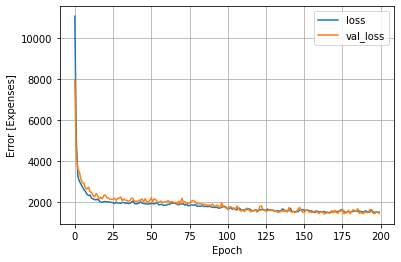

In [20]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [Expenses]')
ax.legend()
ax.grid(True)


In [21]:
# just renaming test dataset instead of modifying test block var names
test_dataset = test_features

# Evaluate Model

9/9 - 0s - loss: 2069.5251 - mean_absolute_error: 2069.5251 - mean_squared_error: 31261412.0000 - 32ms/epoch - 4ms/step
Testing set Mean Abs Error: 2069.53 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


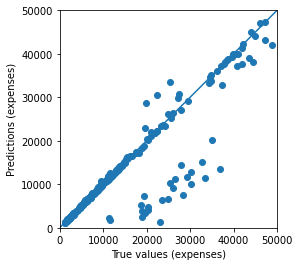

In [22]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
